In [7]:
include("astrobee_se3_script.jl")
using Plots

N = 50
MAX_ITERATIONS_NB = 100

model = Astrobee()

Xp,Up = initialize_trajectory(model, N)
X, U  = copy(Xp) .+ 2., copy(Up) .+ 2.

SCPproblem = GuSTOProblem(model, N, Xp, Up)

x_dim, u_dim = model.x_dim, model.u_dim

Delta0, omega0, omegamax, 
    epsilon, rho0, rho1, 
    beta_succ, beta_fail, gamma_fail, 
    convergence_threshold = get_initial_gusto_parameters(model)

Delta = Delta0
omega = omega0

# X = zeros(x_dim, N)
# U = zeros(u_dim, N-1)
println("oh yeah")

oh yeah


In [8]:

#     problem = Model(with_optimizer(Ipopt.Optimizer, print_level=0))

In [9]:
gamma_fail

5.0

In [10]:
beta_fail

0.5

In [11]:
include("astrobee_se3_script.jl")

X_all, U_all, x_shooting_all = [], [], []
push!(X_all, copy(X))
push!(U_all, copy(U))

B_success = false
it = 0

while it<MAX_ITERATIONS_NB && 
        !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
            convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
        omega<omegamax
    println("-----------")
    println("Iteration $it")
    println("metric=$(convergence_metric(model,X,U,Xp,Up))")
    println("-----------")
    
#     omega, Delta = SCPproblem.omega, SCPproblem.Delta
    
    Xp = copy(X)
    Up = copy(U)
    
    model.f, model.A, model.B = compute_dynamics(model, Xp, Up)
    
    reset_problem(SCPproblem, model)
    set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
    define_cost(SCPproblem, model)
    define_constraints(SCPproblem, model)
    
    JuMP.optimize!(SCPproblem.solver_model)    
    p0 = get_initial_constraint_dual_variable(SCPproblem, model)
    
    # get solution
    X_sol = JuMP.value.(SCPproblem.X)
    U_sol = JuMP.value.(SCPproblem.U)
    
    # try shooting
    #x_shooting, sol_newton = solve_shooting(SCPproblem, model, p0)
#     x_shooting = solve_shooting_once(SCPproblem, model, p0)
    #push!(x_shooting_all, x_shooting)
    
    # -----------
    # GuSTO Logic
    if it > 2
        if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
            rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

            if rho > rho1
                println("Reject solution.")
                Delta = beta_fail * Delta
                omega     = omega
                B_success = false

            else
                println("Accept solution.")
                X = copy(X_sol)
                U = copy(U_sol)
                B_success = true
                if rho < rho0
                    Delta = min(beta_succ*Delta, Delta0)
                else
                    Delta = Delta
                end
                if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                    omega = omega0
                else
                    println("Solution does not satisfy state constraints, increasing omega.")
                    omega = gamma_fail * omega
                    B_success = false
                end
            end

        else
            println("Reject solution (Outside trust region)")
            Delta = Delta
            omega     = gamma_fail * omega
            B_success = false
        end
    else # always accept first solution
        X = copy(X_sol)
        U = copy(U_sol)
    end
        
                    
    # -----------

    push!(X_all, copy(X))
    push!(U_all, copy(U))
                    
    
    it += 1
    
    println("Parameters:")
    println("omega=$omega")
    println("delta=$Delta")
end


-----------
Iteration 0
metric=94.24868789068172
-----------
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 1
metric=92.41705808120503
-----------
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 2
metric=156.78723769328187
-----------
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 3
metric=87.1807371992379
-----------
Accept solution.
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 4
metric=224.77512597807325
-----------
Accept solution.
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 5
metric=245.8113517352682
-----------
Accept solution.
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 6
metric=60.3817796724378
-----------
Accept solution.
Parameters:
omega=1.0
delta=1000.0
-----------
Iteration 7
metric=52.44483329015121
-----------
Accept solution.
Solution does not satisfy state constraints, increasing omega.
Parameters:
omega=5.0
delta=1000.0
-----------
Iteration 8
metric=27.248546532600717
-----------
Accept solution.
Param

In [6]:
gamma_fail

5.0

In [47]:
include("astrobee_se3_script.jl")

x_shooting, sol_newton = solve_shooting(SCPproblem, model, get_initial_constraint_dual_variable(SCPproblem, model))
x_shooting = solve_shooting_once(SCPproblem, model, sol_newton.zero)

UndefVarError: UndefVarError: shooting_ode_func! not defined

In [48]:
xN = x_shooting[:,end]

for i = 1:x_dim
    Fi = model.x_final[i] - xN[i]
    @show Fi
end

UndefVarError: UndefVarError: x_shooting not defined

In [49]:

    for x_shooting in x_shooting_all
        if size(x_shooting,1) > 1
        @show minimum(x_shooting)
        end
end

In [50]:
x_shooting_all

0-element Array{Any,1}

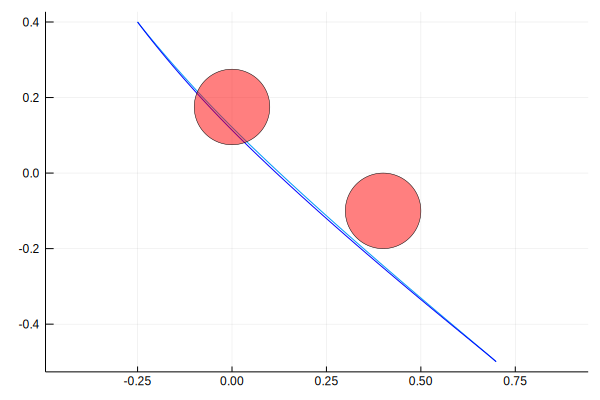

In [51]:
include("astrobee_se3_script.jl")
#plot(X[1,:],X[2,:])

plot_solutions(SCPproblem, model, X_all[end-1:end], U_all[end-1:end]; x_shooting_all=x_shooting_all)

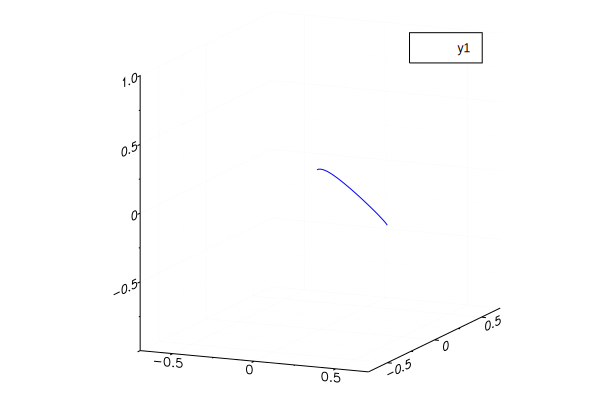

In [52]:
X = X_all[end]
# Xs = x_shooting_all[2]
 fig = plot(X[1,:], X[2,:], X[3,:]; c=:blue, lims = (-0.7,0.7))
# plot!(fig, Xs[1,:], Xs[2,:], Xs[3,:]; c=:red)

xlims = (0,10)
zlims = (0,10)
fig

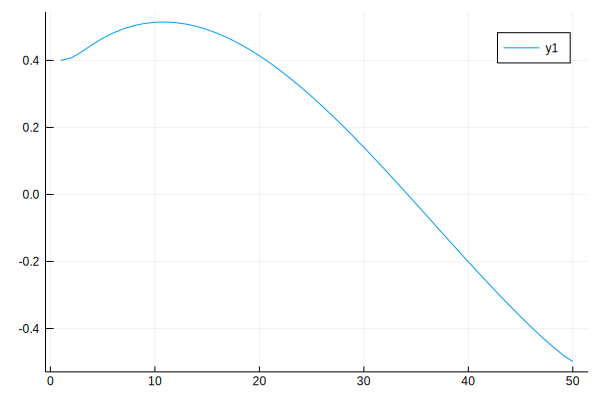

In [53]:
idx = [1,2]
x = X_all[2][1,:]
y = X_all[2][2,:]
z = X_all[2][3,:]
# plot(x,  y)
plot(1:N, y)